In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [21]:
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = y_test, np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [22]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

data = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/최효정논문/PRSA_data_2010.1.1-2014.12.31.csv")

In [23]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad

def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [24]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


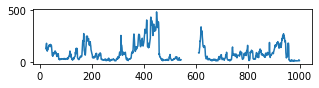

In [25]:
plt.figure(figsize=(5,1))
plt.plot(data['pm2.5'][:1000])

In [26]:
data['cbwd']=data['cbwd'].factorize()[0]

In [27]:
#data.drop(['cbwd'], axis=1, inplace=True)

In [28]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [29]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,0,1.79,0,0
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,0,4.92,0,0
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,0,6.71,0,0
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,0,9.84,0,0
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,0,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,0,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,0,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,0,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,0,246.72,0,0


In [30]:
data.columns[5:]

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [31]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [32]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

35059 4382 4383 8765


In [33]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [34]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

35035
4358
4359
8741


In [35]:
print(trainX.shape)
print(trainY.shape)

(35035, 24, 8)
(35035,)


# new

In [ ]:
first_input = Input(shape=(24,8))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad=MaxPooling1D(pool_size=2)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1])
#ad1=MaxPooling1D(pool_size=2)(ad1)

#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(in1)
#in1=Dropout(0.5)(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/pm2.5_lstmrescnn_onestep_.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 24, 8)]      0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 24, 64)       18688       input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_39 (Conv1D)              (None, 24, 64)       12352       lstm_9[0][0]                     
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 24, 64)       8256        conv1d_39[0][0]                  
______________________________________________________________________________________

In [ ]:
hist = model.fit([trainX],trainY, epochs = 130,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Epoch 1/130
349/351 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00001: val_loss improved from inf to 0.00070, saving model to saved_weights\pm2.5_lstmrescnn_onestep_.hdf5
351/351 [==============================] - 8s 21ms/step - loss: 0.0018 - val_loss: 7.0218e-04
Epoch 2/130
349/351 [============================>.] - ETA: 0s - loss: 6.6971e-04
Epoch 00002: val_loss did not improve from 0.00070
351/351 [==============================] - 7s 21ms/step - loss: 6.6869e-04 - val_loss: 8.5988e-04
Epoch 3/130
351/351 [==============================] - ETA: 0s - loss: 5.2177e-04
Epoch 00003: val_loss improved from 0.00070 to 0.00051, saving model to saved_weights\pm2.5_lstmrescnn_onestep_.hdf5
351/351 [==============================] - 8s 22ms/step - loss: 5.2177e-04 - val_loss: 5.0809e-04
Epoch 4/130
349/351 [============================>.] - ETA: 0s - loss: 5.0535e-04
Epoch 00004: val_loss did not improve from 0.00051
351/351 [==============================] - 9s 24ms/ste

KeyboardInterrupt: 

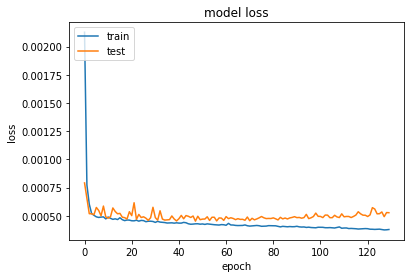

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

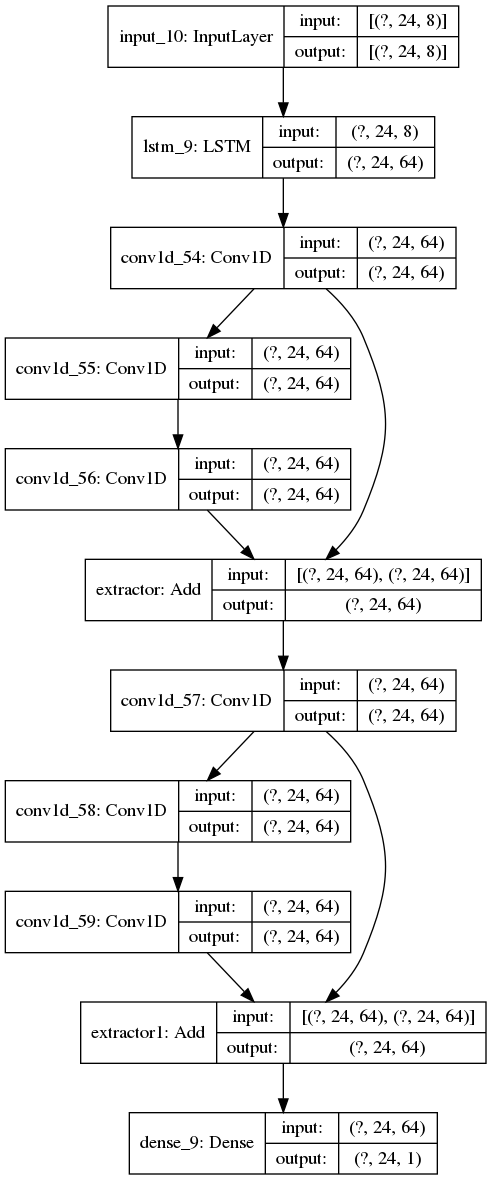

In [ ]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
%matplotlib inline
dot_img_file = './model_1.png'

plot_model(model, to_file=dot_img_file, show_shapes=True)


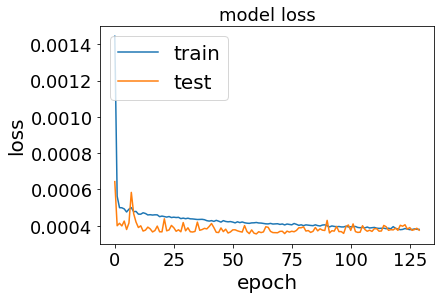

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('saved_weights/pm2.5_lstmcnn_onestep.hdf5')

(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

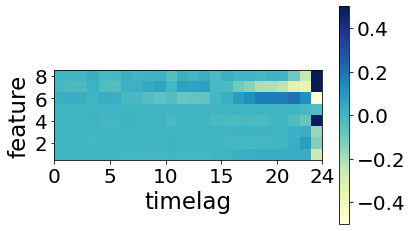

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5,7.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 8], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

In [ ]:
model.load_weights('saved_weights/pm2.5_lstmrescnn_onestep_.hdf5')

(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

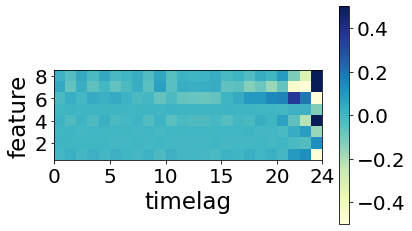

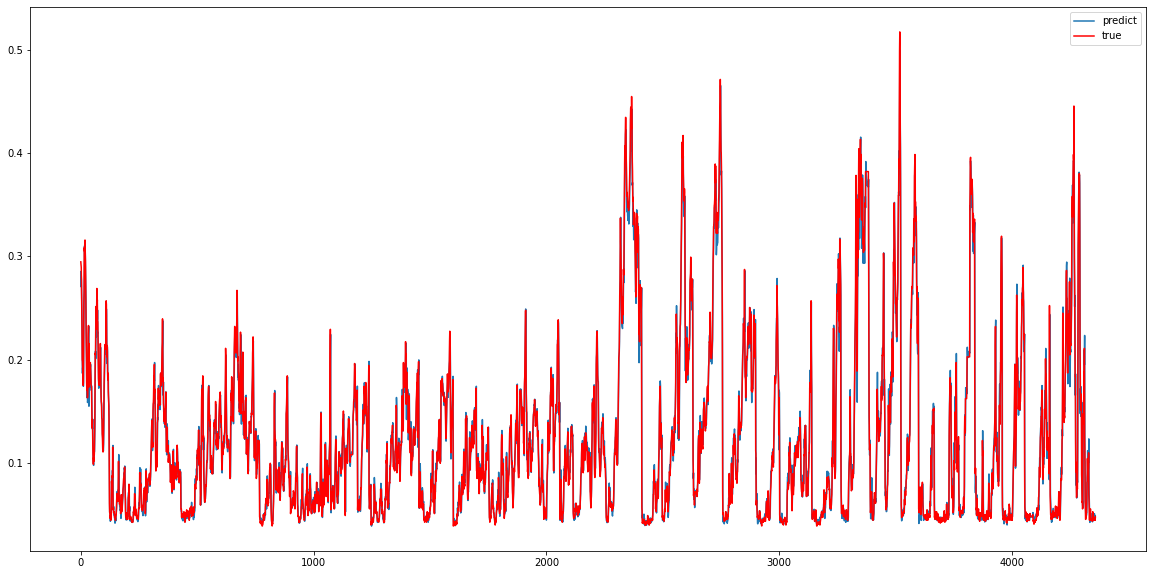

Test RMSE: 0.01614
Test MAE: 0.00951
Test MSE: 0.00026
Test MAPE: 0.08687
Test RMSE: 17.53317
Test MAE: 10.32936
Test MAPE: 0.21511


In [ ]:

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

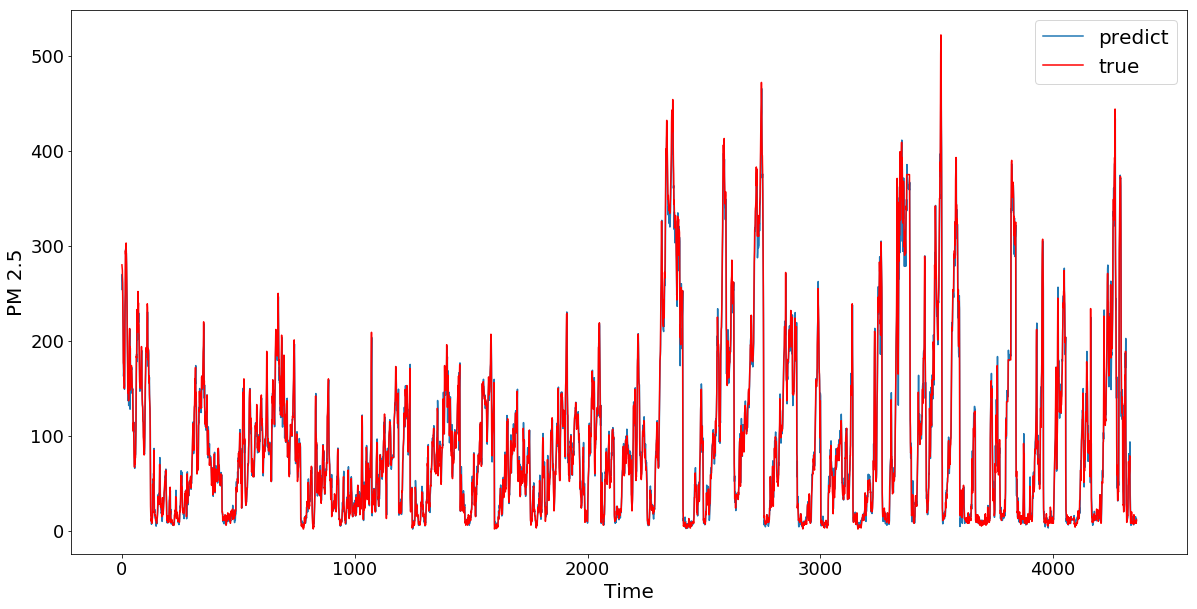

In [ ]:
plt.figure(figsize=(20,10))
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()

plt.ylabel('PM 2.5')
plt.xlabel('Time')

pyplot.show()

In [ ]:
model.load_weights('saved_weights/pm2.5_lstmrescnn_onestep_maxpool.hdf5')

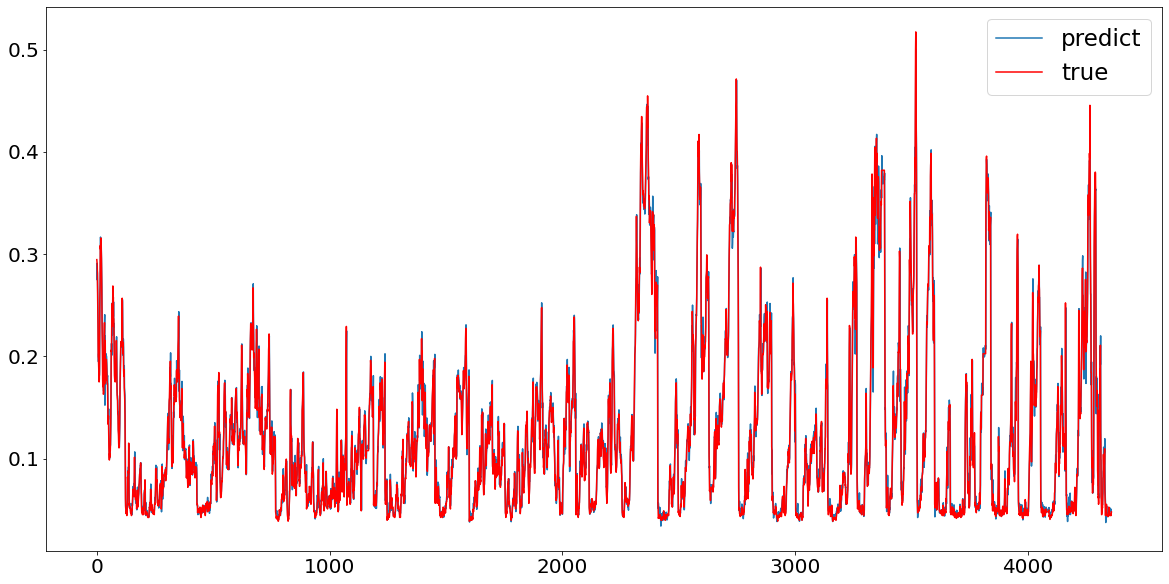

Test RMSE: 0.01619
Test MAE: 0.00948
Test MSE: 0.00026
Test MAPE: 0.08793
Test RMSE: 17.58530
Test MAE: 10.29920
Test MAPE: 0.22478


In [ ]:

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)

In [ ]:
model.load_weights('saved_weights/pm2.5_lstmrescnn_onestep.hdf5')

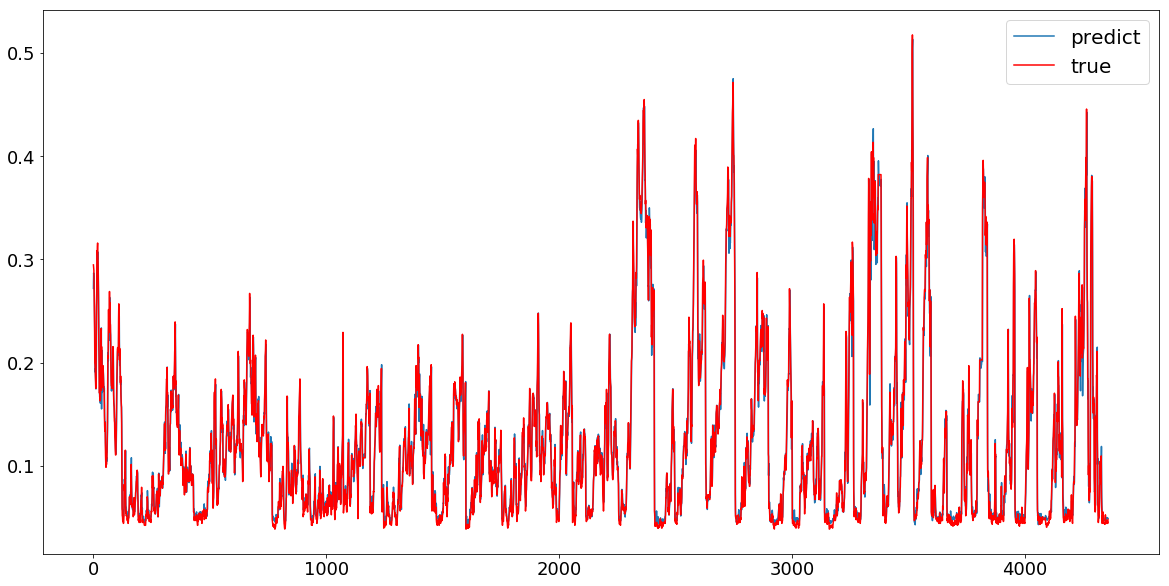

Test RMSE: 0.01619
Test MAE: 0.00961
Test MSE: 0.00026
Test RMSE: 17.58256
Test MAE: 10.44060
Test MSE: 309.14642


In [ ]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
mse=mean_squared_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MSE: %.5f' % mse)

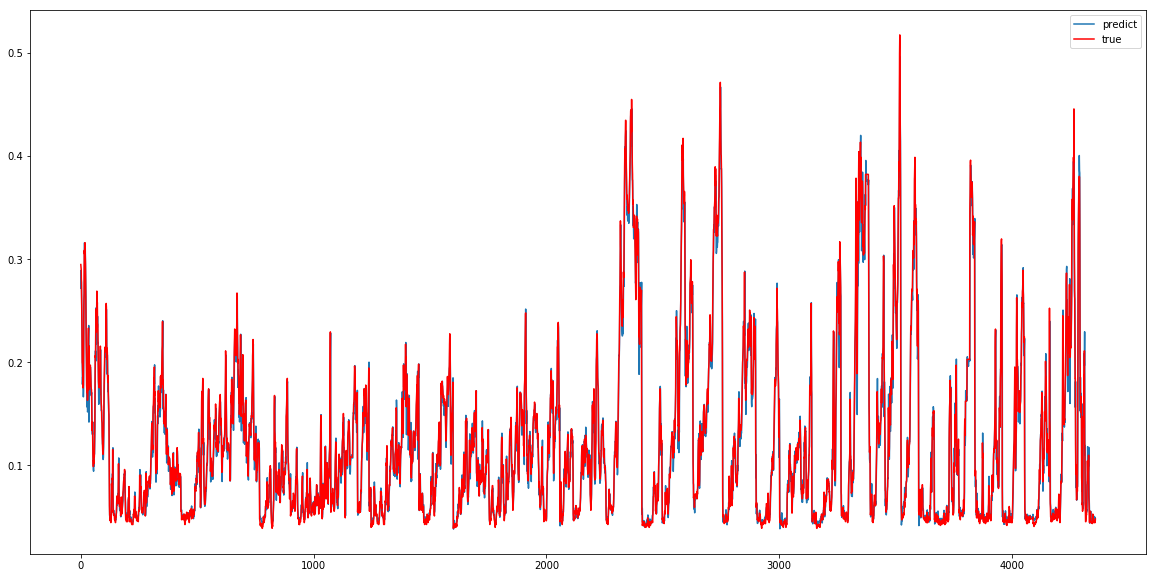

Test RMSE: 0.01629
Test MAE: 0.00958
Test MSE: 0.00027
Test RMSE: 17.69187
Test MAE: 10.40597


In [ ]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


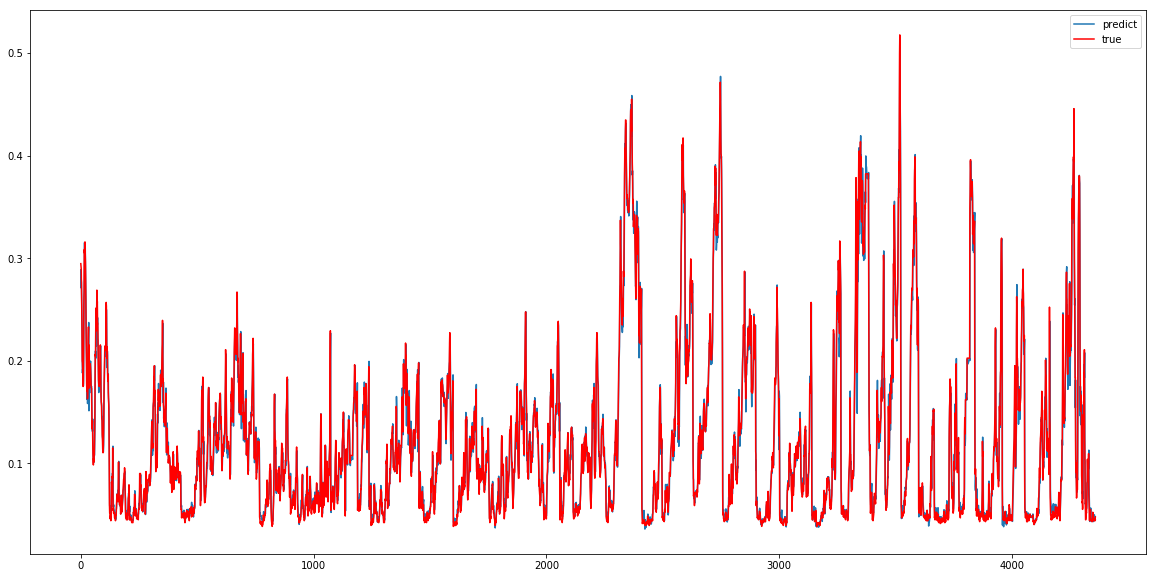

Test RMSE: 0.01629
Test MAE: 0.00961
Test MSE: 0.00027
Test RMSE: 17.69346
Test MAE: 10.44088


In [ ]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


In [ ]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

In [ ]:
id_=24*8
X_test=testX.copy()

testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([28., 28., 25., 15., 17., 18., 35., 17., 17., 18., 24., 28., 31.,
       40., 42., 48., 52., 53., 58., 58., 64., 61., 41., 35.],
      dtype=float32)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


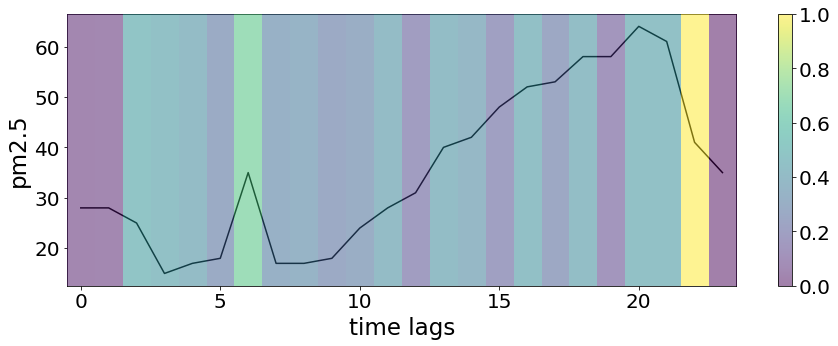

In [ ]:
from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


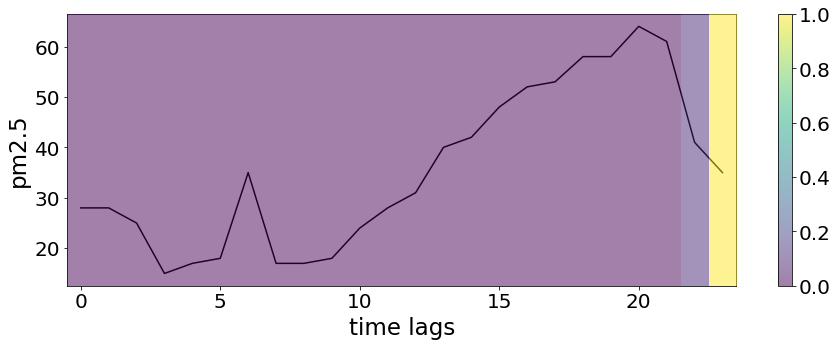

In [ ]:
from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

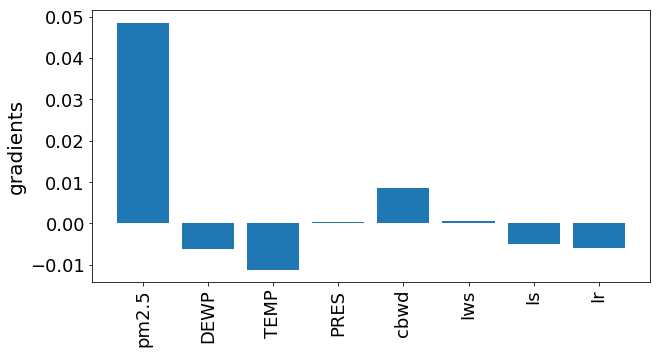

In [ ]:

columns=data.columns[5:]
X_test=testX.copy()

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

[0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


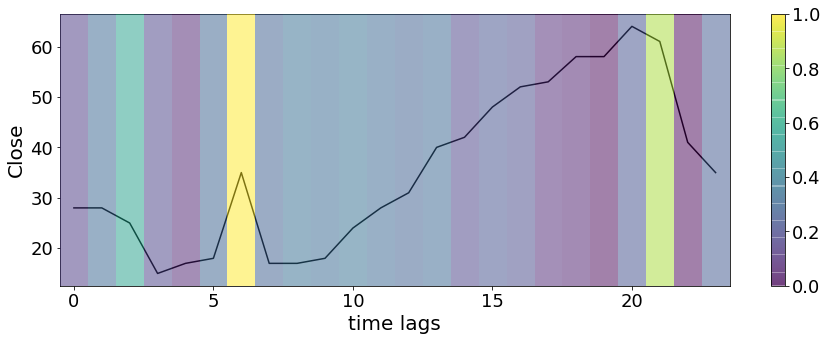

In [ ]:
from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import random
import pylab



X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('Close'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')
#pylab.pcolor(np.vstack([activation]*120),cmap='jet',alpha=0.35)

#pylab.colorbar()

np.set_printoptions(False)

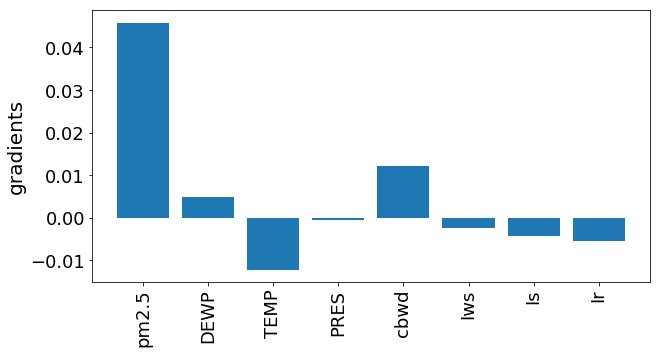

In [ ]:

columns=data.columns[5:]
X_test=testX.copy()

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(10,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

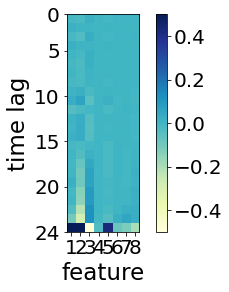

In [ ]:
####lstm-cnn

import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 8, 0 , 24]
x_label_list = [1,2,3,4,5,6,7,8,9]
y_label_list = [24,20,15,10,5,0]
ax.set_yticks([0,5,10,15,20,24])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 8, 0 , 24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()


(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

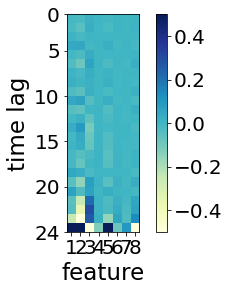

In [ ]:
##residual

import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = gradient_weight(X_test[55], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 8, 0 , 24]
x_label_list = [1,2,3,4,5,6,7,8,9]
y_label_list = [24,20,15,10,5,0]
ax.set_yticks([0,5,10,15,20,24])

ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('time lag')
ax.set_xlabel('feature')

plt.imshow(a,extent = [0 , 8, 0 , 24], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()


### CNN-LSTM

In [55]:
first_input = Input(shape=(24,8))

in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
#in1=Flatten()(in1)
#in1=Dense(50, activation='relu')(in1)
in1=LSTM(64)(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_cnnlstm_onestep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
extractor (Conv1D)           (None, 24, 64)            4160

In [56]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 24, 64)            1088      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
extractor (Conv1D)           (None, 24, 64)            4160

In [57]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200
351/351 [==============================] - 4s 6ms/step - loss: 0.0012 - val_loss: 5.6139e-04

Epoch 00001: val_loss improved from inf to 0.00056, saving model to saved_weights/pm2.5_cnnlstm_onestep.hdf5
Epoch 2/200
351/351 [==============================] - 2s 5ms/step - loss: 5.5328e-04 - val_loss: 6.4885e-04

Epoch 00002: val_loss did not improve from 0.00056
Epoch 3/200
351/351 [==============================] - 2s 5ms/step - loss: 5.6527e-04 - val_loss: 5.2868e-04

Epoch 00003: val_loss improved from 0.00056 to 0.00053, saving model to saved_weights/pm2.5_cnnlstm_onestep.hdf5
Epoch 4/200
351/351 [==============================] - 2s 5ms/step - loss: 5.3172e-04 - val_loss: 5.7615e-04

Epoch 00004: val_loss did not improve from 0.00053
Epoch 5/200
351/351 [==============================] - 2s 5ms/step - loss: 5.0509e-04 - val_loss: 5.1678e-04

Epoch 00005: val_loss improved from 0.00053 to 0.00052, saving model to saved_weights/pm2.5_cnnlstm_onestep.hdf5
Epoch 6/200
351/3

In [20]:
#model.load_weights("saved_weights/pm2.5_cnnlstm_onestep.hdf5")

(1, 24, 8)


<Figure size 1080x5040 with 0 Axes>

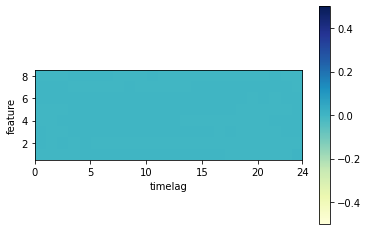

In [18]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5,7.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 8], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

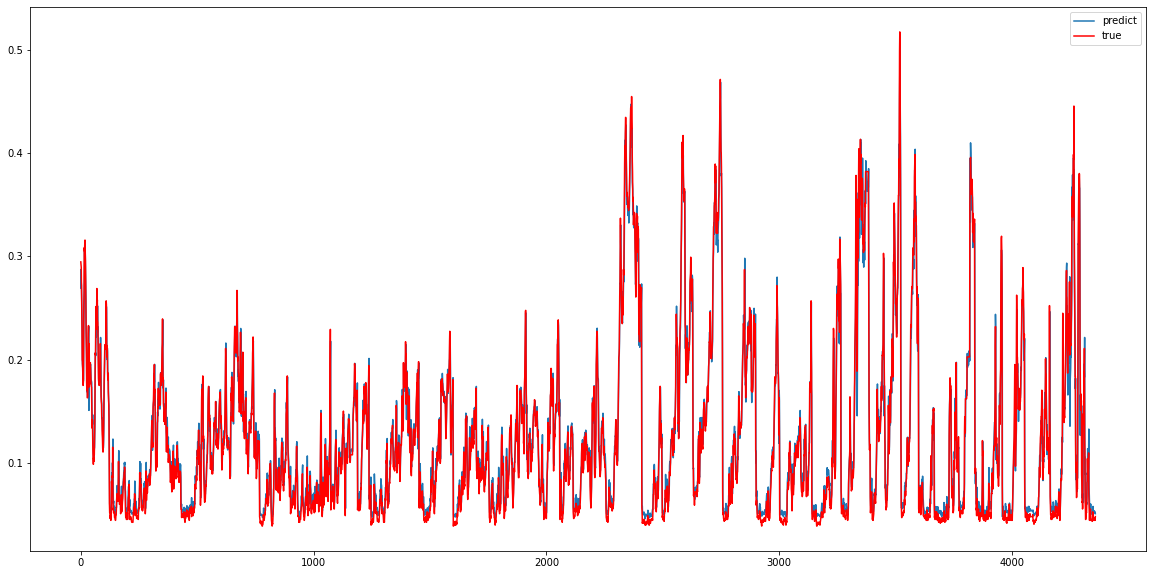

Test RMSE: 0.01692
Test MAE: 0.01064
Test MSE: 0.00029
Test MAPE: 86.53849
Test RMSE: 18.37879
Test MAE: 11.54981
Test MAPE: 289.92858


In [58]:
#1dcnn(5,1)-lstm

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)


In [ ]:
id_=100
X_test=testX.copy()
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([157.     , 153.     , 153.     , 149.99998, 158.     , 168.     ,
       167.     , 184.     , 194.     , 181.     , 153.     , 139.     ,
       133.     , 130.     , 116.     , 114.     ,  99.     ,  94.     ,
        84.     ,  80.     ,  80.     ,  88.     , 103.     , 132.     ],
      dtype=float32)

In [ ]:
len(activation)

24

[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.]


(-0.5, 23.5, 119.5, -0.5)

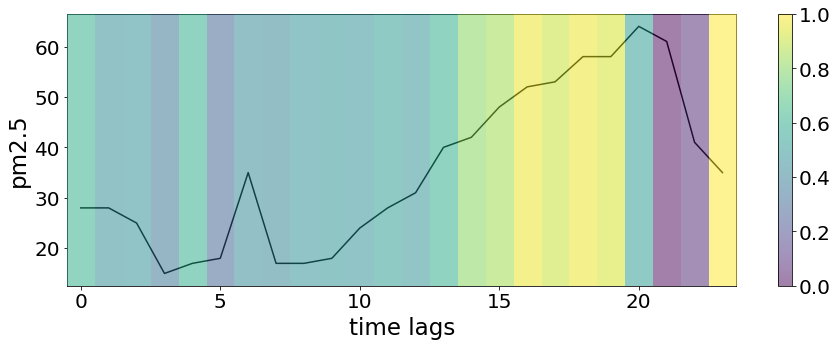

In [ ]:
from scipy.ndimage import zoom
import random
import pylab




X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))
label=[0,5,10,15,20]
plt.xticks(np.arange(0,24,5),label)

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')

### LSTM-CNN

In [95]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')


In [96]:
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 24, 8)]           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 24, 150)           95400     
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 22, 64)            28864     
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 21, 64)            8256      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 21, 64)            4160      
_________________________________________________________________
extractor (MaxPooling1D)     (None, 10, 64)            0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 640)               0  

In [97]:
checkpoint_path = "saved_weights/pm2.5_lstmcnn_150_5_1_.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [98]:
history=model.fit(trainX, trainY, epochs=150, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/150
351/351 [==============================] - 3s 6ms/step - loss: 0.0030 - val_loss: 0.0019

Epoch 00001: val_loss improved from inf to 0.00194, saving model to saved_weights/pm2.5_lstmcnn_150_5_1_.hdf5
Epoch 2/150
351/351 [==============================] - 2s 5ms/step - loss: 0.0016 - val_loss: 0.0015

Epoch 00002: val_loss improved from 0.00194 to 0.00145, saving model to saved_weights/pm2.5_lstmcnn_150_5_1_.hdf5
Epoch 3/150
351/351 [==============================] - 2s 5ms/step - loss: 0.0013 - val_loss: 0.0014

Epoch 00003: val_loss improved from 0.00145 to 0.00144, saving model to saved_weights/pm2.5_lstmcnn_150_5_1_.hdf5
Epoch 4/150
351/351 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 0.0011

Epoch 00004: val_loss improved from 0.00144 to 0.00110, saving model to saved_weights/pm2.5_lstmcnn_150_5_1_.hdf5
Epoch 5/150
351/351 [==============================] - 2s 5ms/step - loss: 0.0011 - val_loss: 0.0013

Epoch 00005: val_loss did not improve 

In [ ]:
#model.load_weights("saved_weights/pm2.5_lstmcnn_150_5_1_.hdf5")


ValueError: You are trying to load a weight file containing 4 layers into a model with 5 layers.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX

grad_weight = gradient_weight(X_test[4], model)

#grad_weight=grad_weight.reshape(48,4)

print(grad_weight.shape)
plt.figure(figsize=(15,70))

#plt.plot(X_test[8], 'k')
a=grad_weight.numpy()
a=a.reshape(24,8)
a=a.transpose()

#print(a)
fig, ax = plt.subplots(1,1)

extent = [0 , 24, 0 , 8]
y_label_list = [2,4,6,8]
x_label_list = [0,5,10,15,20,24]
ax.set_xticks([0,5,10,15,20,24])

ax.set_yticks([1.5,3.5,5.5,7.5])

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)
ax.set_ylabel('feature')
ax.set_xlabel('timelag')

plt.imshow(a,extent = [0 , 24, 0 , 8], vmin=-0.5, vmax=0.5, cmap="YlGnBu", interpolation='nearest')
plt.colorbar()

plt.show()

In [ ]:
id_=105
X_test=testX.copy()
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([168.     , 167.     , 184.     , 194.     , 181.     , 153.     ,
       139.     , 133.     , 130.     , 116.     , 114.     ,  99.     ,
        94.     ,  84.     ,  80.     ,  80.     ,  88.     , 103.     ,
       132.     , 151.     , 164.99998, 182.     , 191.     , 193.     ],
      dtype=float32)

In [ ]:
len(testX_inverse)

24

[0.8685908  0.68548745 0.5023841  0.3292737  0.15741241 0.10340023
 0.08305408 0.06079823 0.03758152 0.01752363 0.         0.00607742
 0.04168919 0.13596128 0.34759006 0.5524928  0.73386663 0.9006234
 0.95031166 1.        ]


(-0.5, 19.5, 119.5, -0.5)

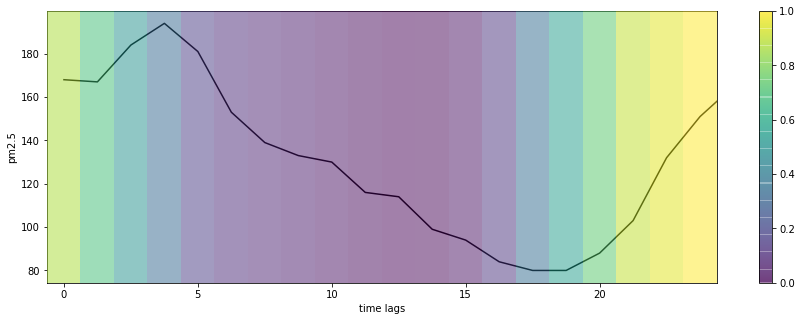

In [ ]:
from scipy.ndimage import zoom
import random
import pylab




X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))
label=[0,5,10,15,20]
plt.xticks(np.arange(0,20,4),label)

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')

In [ ]:
len(activation)

20

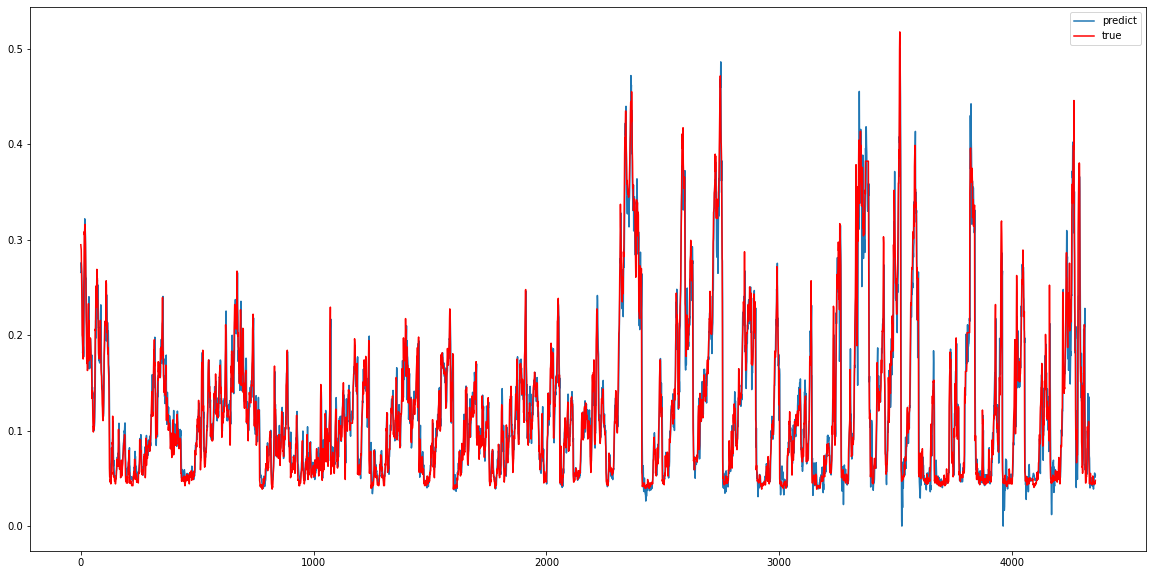

Test RMSE: 0.02579
Test MAE: 0.01596
Test MSE: 0.00067
Test RMSE: 28.00772
Test MAE: 17.33476


In [99]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

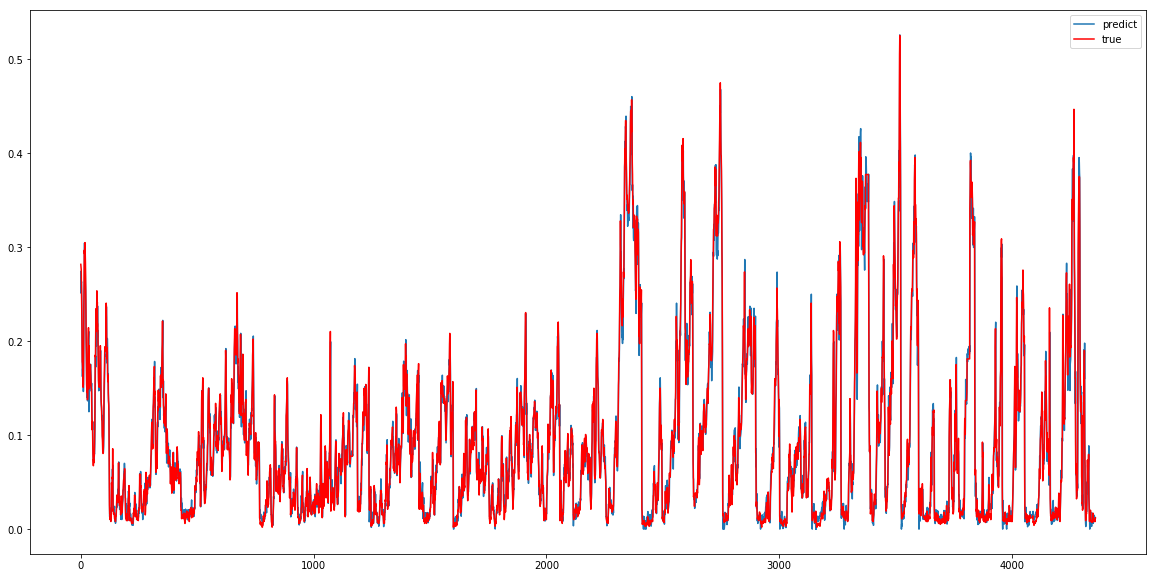

Test RMSE: 0.01789
Test MAE: 0.01100
Test MSE: 0.00032
Test RMSE: 19.43214
Test MAE: 11.94186


In [ ]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### Timedistributed 1d-CNN

In [17]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,24,11))

in1=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(first_input)
#in1= BatchNormalization(scale=False)(in1)
#in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_conv1d_timedist_5_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

# fit model9
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200


ValueError: ignored

In [ ]:
#model.load_weights("saved_weights/pm2.5_conv1d_5_1.hdf5")

In [101]:
#1dcnn(5,3,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


ValueError: ignored

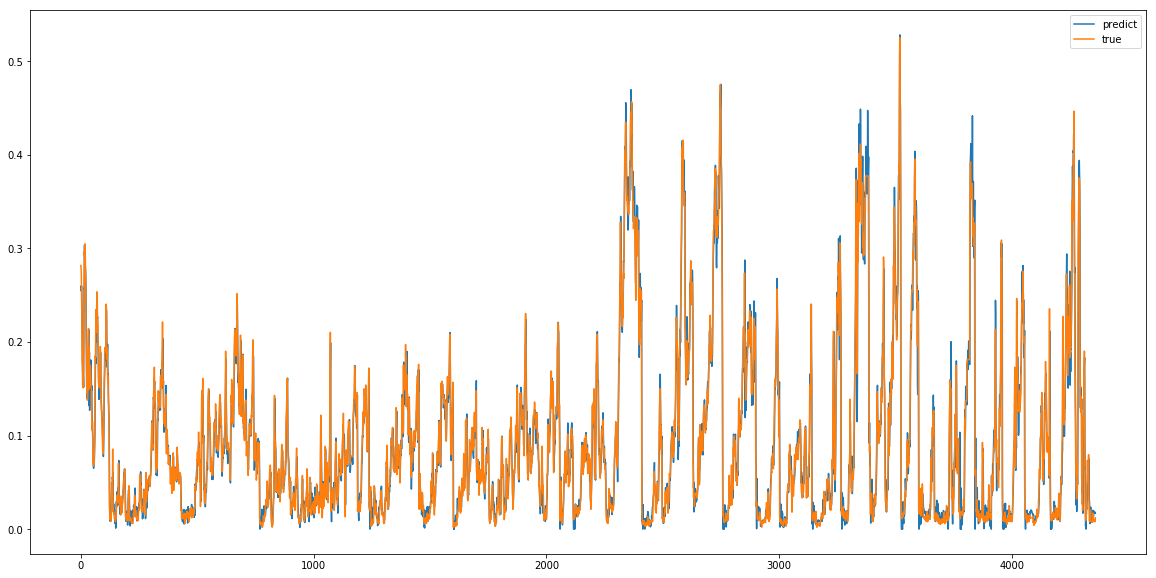

Test RMSE: 0.01985
Test MAE: 0.01248
Test MSE: 0.00039
Test RMSE: 21.55784
Test MAE: 13.55454


In [ ]:
# time 1dcnn(5,3,1)

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


### Bidirectional LSTM

In [18]:
from tensorflow.keras.models import Model

first_input = Input(shape=(24,8))

in1=Bidirectional(LSTM(85))(first_input)
in1=Dense(1,activation='relu')(in1)
model=Model(first_input,in1)
model.compile(optimizer='adam', loss='mse')
model.summary()
checkpoint_path = "saved_weights/pm2.5_timebilstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model
model.fit(trainX, trainY,validation_data=[valX,valY], epochs=50, verbose=1,callbacks=[cb])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 170)               63920     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 171       
Total params: 64,091
Trainable params: 64,091
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1087/1095 [============================>.] - ETA: 0s - loss: 0.0231

ValueError: ignored

In [ ]:
#model.load_weights("saved_weights/pm2.5_timebilstm.hdf5")

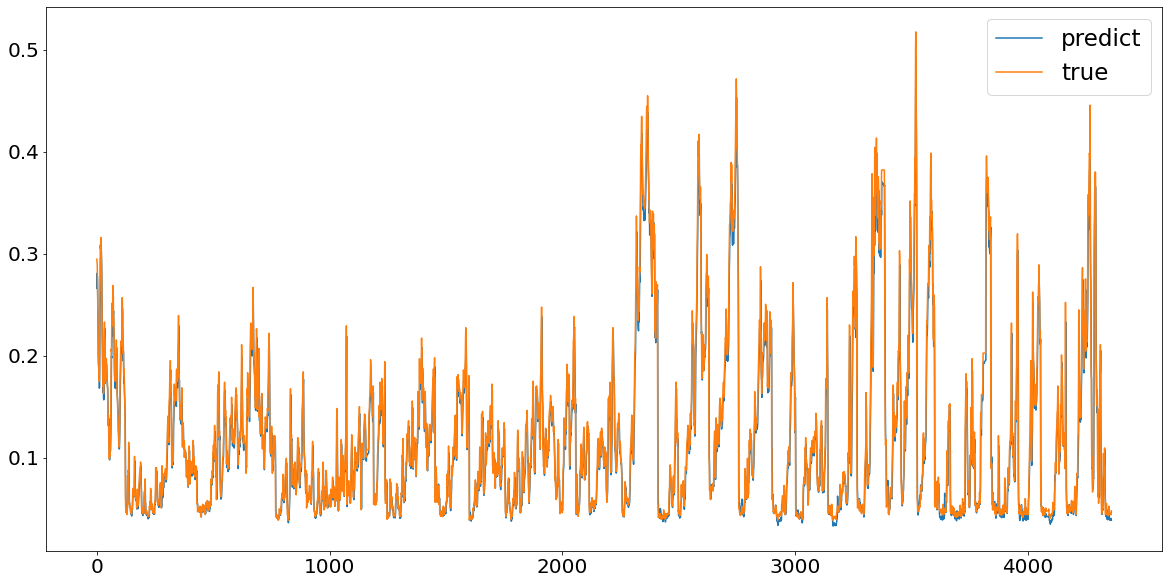

Test RMSE: 0.01797
Test MAE: 0.01113
Test MSE: 0.00032
Test MAPE: 0.09932
Test RMSE: 19.51308
Test MAE: 12.09190
Test MAPE: 0.24681


In [ ]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)


### 1d-CNN

In [36]:
first_input = Input(shape=(24,8))

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)
in1=Flatten()(in1)
in1=Dense(20, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/pm2.51.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 24, 8)]           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 64)            1088      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 24, 64)            8256      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 24, 64)            4160      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 24, 64)            8256      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 24, 64)            4160

In [37]:
model.fit(trainX, trainY,validation_data=[valX,valY],epochs=200, verbose=1,callbacks=[cb])

Epoch 1/200
1088/1095 [============================>.] - ETA: 0s - loss: 8.2373e-04

ValueError: ignored

In [ ]:
#model.load_weights("saved_weights/pm2.51.hdf5")

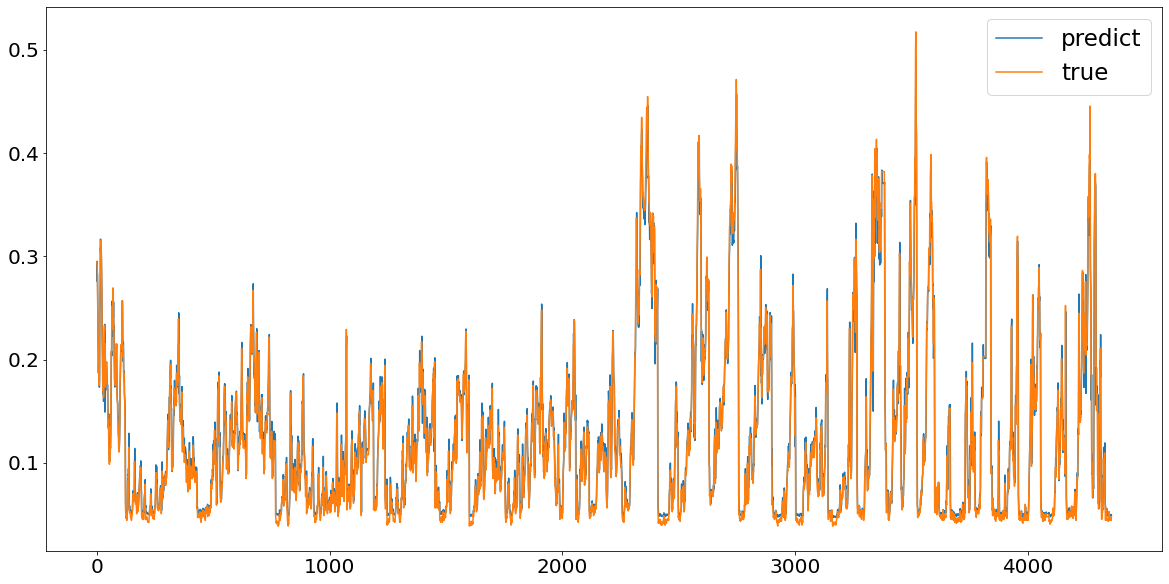

In [ ]:
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

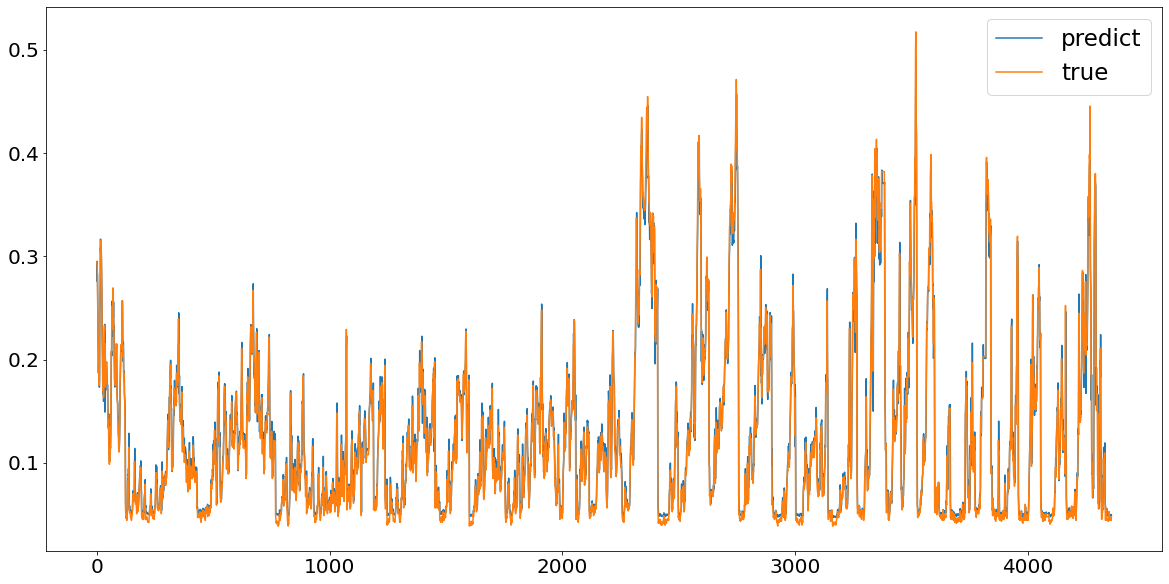

Test RMSE: 0.01678
Test MAE: 0.01013
Test MSE: 0.00028
Test MAPE: 0.09820
Test RMSE: 18.21987
Test MAE: 11.00575
Test MAPE: 0.28966


In [ ]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)


In [ ]:
##1dcnn

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

Test RMSE: 0.01665
Test MAE: 0.01034


In [ ]:
id_=100
X_test=testX.copy()
testX_inverse=X_test[id_][:,0]*(np.max(values)-np.min(values))+np.min(values)
testX_inverse

array([157.     , 153.     , 153.     , 149.99998, 158.     , 168.     ,
       167.     , 184.     , 194.     , 181.     , 153.     , 139.     ,
       133.     , 130.     , 116.     , 114.     ,  99.     ,  94.     ,
        84.     ,  80.     ,  80.     ,  88.     , 103.     , 132.     ],
      dtype=float32)

[0.10950363 0.3723971  0.63523    0.8027845  0.96077484 0.9937651
 0.9989709  1.         0.9994552  0.9900121  0.97548425 0.9659201
 0.96047217 0.9312954  0.8735472  0.83226395 0.8197942  0.8030872
 0.7751816  0.7716707  0.8783293  0.93286926 0.46646488 0.        ]


(-0.5, 23.5, 119.5, -0.5)

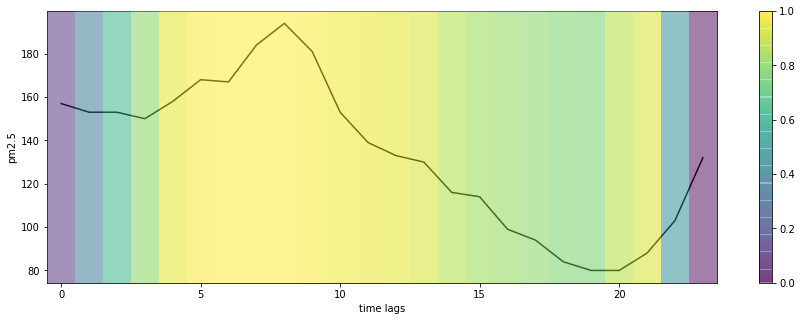

In [ ]:
from scipy.ndimage import zoom
import random
import pylab




X_test=testX.copy()
activation = activation_grad(X_test[id_], model)
print(activation)
plt.figure(figsize=(15,5))
label=[0,5,10,15,20]
plt.xticks(np.arange(0,24,5),label)

plt.plot(testX_inverse, 'k')
#plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('pm2.5'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*120), alpha=0.5, cmap='viridis')
plt.axis('off'); plt.colorbar()
plt.axis('off')

### Timedistributed LSTM-CNN

In [38]:
first_input = Input(shape=(None,24,11))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True))(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in1)

#in1=add([in0,in1],name='extractor')
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')




In [39]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, 24, 11)]    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 24, 150)     97200     
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 22, 64)      28864     
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 22, 64)      4160      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 11, 64)      0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 704)         0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           705 

In [40]:
checkpoint_path = "saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [41]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Epoch 1/200


ValueError: ignored

In [ ]:
 model.load_weights("saved_weights/timedistribute_pm2.5_lstmcnn_150_3_1.hdf5")

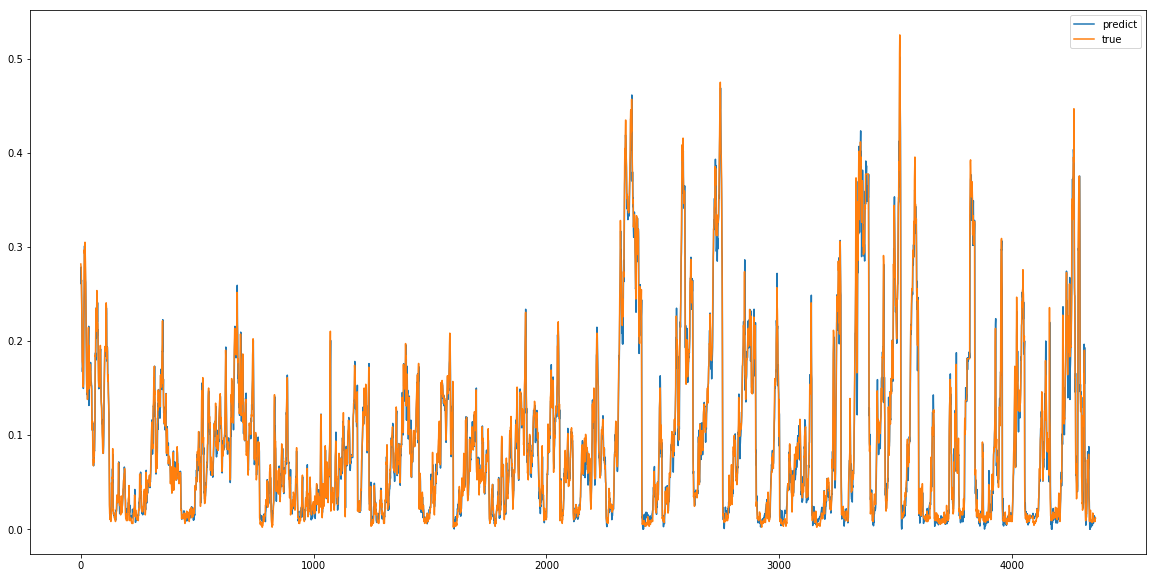

Test RMSE: 0.01806
Test MAE: 0.01101
Test MSE: 0.00033
Test RMSE: 19.61045
Test MAE: 11.95379


In [ ]:
## lstm(150)-cnn(5,1),timedistribute_pm2.5_lstmcnn_150_5_11.hdf5

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae )

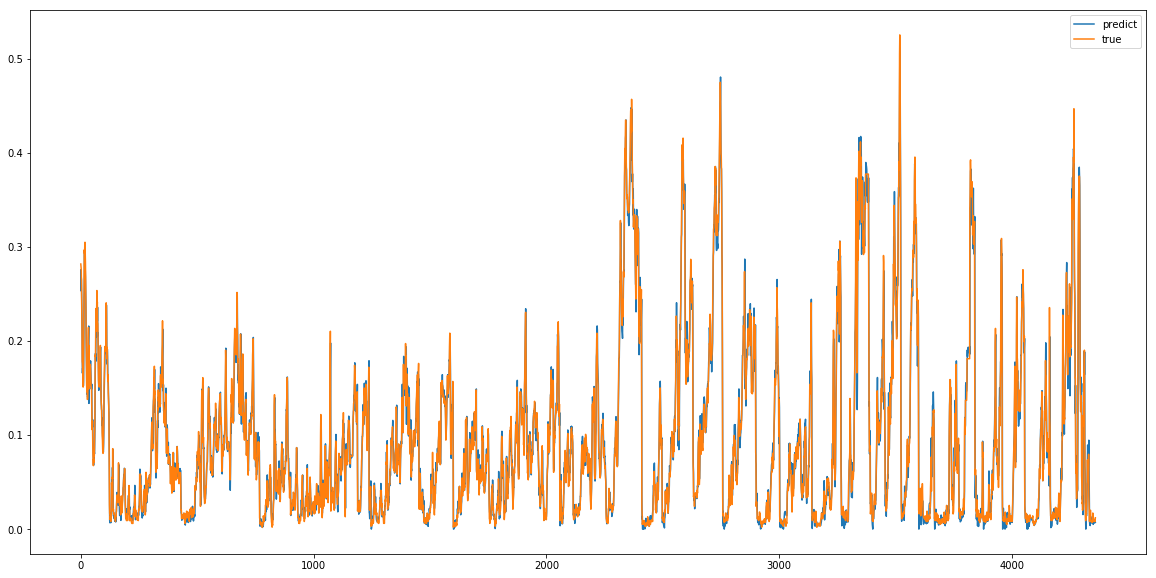

Test RMSE: 0.01770
Test MAE: 0.01071
Test MSE: 0.00031
Test RMSE: 19.21818
Test MAE: 11.63510


In [ ]:
## lstm(150)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)


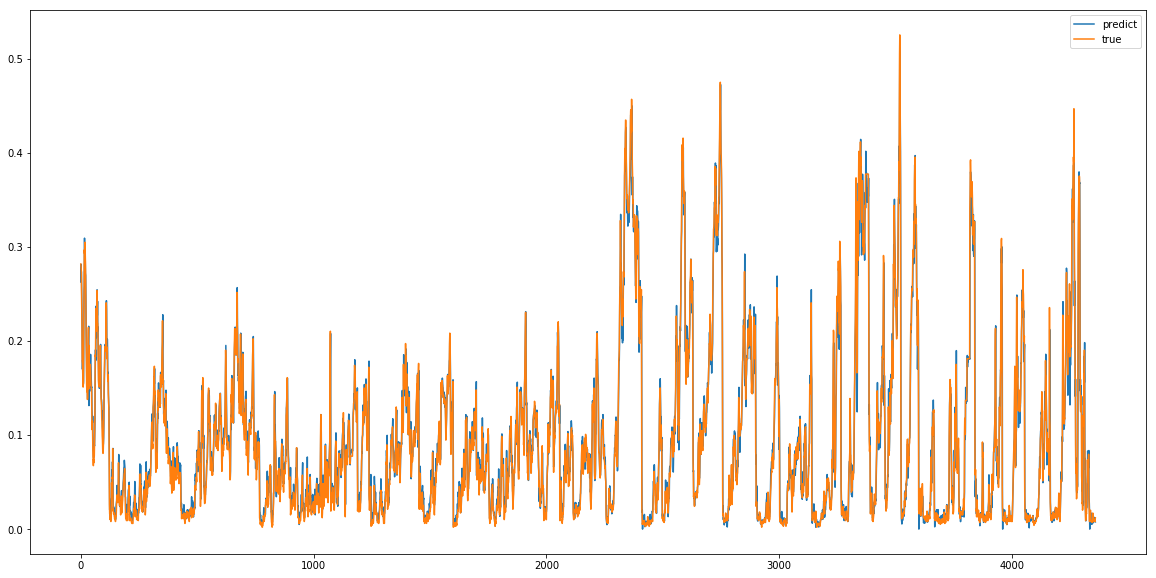

Test RMSE: 0.01783
Test MAE: 0.01091
Test MSE: 0.00032
Test RMSE: 19.36649
Test MAE: 11.85078


In [ ]:
## lstm(100)-cnn(3,1)

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)

In [ ]:
yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)

In [ ]:
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

In [ ]:
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 19.218


In [ ]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

### visualization

In [ ]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

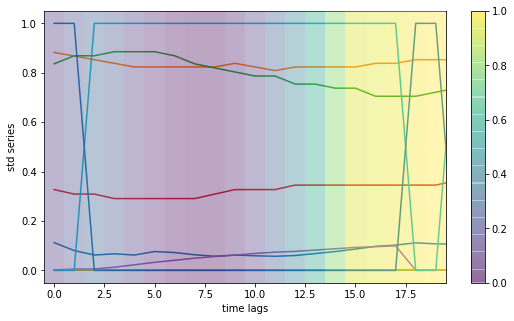

In [ ]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

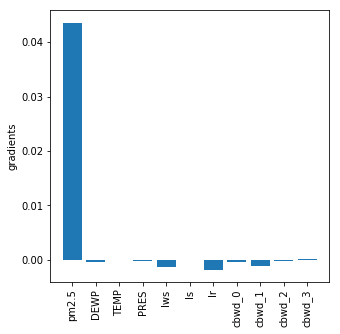

In [ ]:
columns=data.columns[5:]

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

In [ ]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

(1, 24, 11)


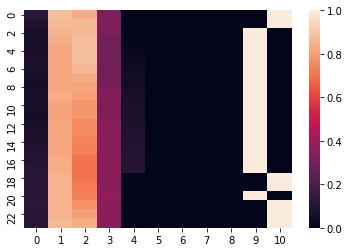

lstm_3/kernel:0 (11, 600)
[[ 0.  0.  0. ...  0. -0.  0.]
 [-0. -0. -0. ...  0. -0.  0.]
 [-0. -0. -0. ...  0. -0.  0.]
 ...
 [-0.  0. -0. ...  0.  0.  0.]
 [-0. -0.  0. ... -0. -0.  0.]
 [-0. -0.  0. ...  0. -0.  0.]]
lstm_3/recurrent_kernel:0 (150, 600)
[[-0.  0.  0. ... -0. -0.  0.]
 [ 0.  0. -0. ...  0.  0. -0.]
 [-0. -0.  0. ... -0.  0. -0.]
 ...
 [ 0. -0. -0. ...  0.  0. -0.]
 [-0. -0. -0. ...  0. -0. -0.]
 [-0.  0.  0. ...  0. -0.  0.]]
lstm_3/bias:0 (600,)
[-0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0.  0.
 -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  1. -0. -0.  0. -0.  0.
  0. -0. -0. -0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.
  0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  0. -0. -0. -0. -0. 

In [ ]:
from tensorflow.keras.models import Model

chars = '0123456789+ '
ctable = CharacterTable(chars)
i = id_
output_final = model.predict(np.array([testX[i]]))

#print(ctable.decode(valX[i]),
 #     ctable.decode(valY[i]),
  #    ctable.decode(output_final[0]))

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
output = intermediate_layer_model.predict(np.array([testX[i]]))
print(output.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# h = np.reshape(output[0], (-1, 8))
# sns.heatmap(h)
sns.heatmap(output[0])
plt.show()

# %% Print weights.
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    print(name, weight.shape)
    print(weight)

In [ ]:
testX

array([[[0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 0., 1.],
        [0., 1., 1., ..., 0., 1., 0.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.]],

       [[0., 1., 1., ..., 0., 0., 1.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.]],

       [[0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 0., 1.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 1., 1., ..., 0., 1., 0.]],

       ...,

       [[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0.